In [1]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylabㅌ
import pandas as pd
import seaborn as sns
import random


from InitializeSpeciesPool import *
from LV import *
from VariousMetrics import *

sns.set_style("ticks")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}



session_name="results/test"


# Function Definition

In [11]:
from scipy.integrate import odeint

'''

def gLV(y, t, I_simul, g_simul, k_simul):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        dydt[i] = g_simul[i]* y[i] * (1- np.sum(I_simul[i,:] * y)/k_simul[i])
    return dydt

def run_lotka_volterra_dynamics(y0, t, s_idx, I, g, k):
    
    s_idx=np.where(s_idx)[0].tolist()
    N=len(y0)
    y0_simul=y0[s_idx]
    I_simul=I[s_idx,:]
    I_simul=I_simul[:,s_idx]
    g_simul=g[s_idx]
    k_simul=k[s_idx]
    
    
    y = odeint(gLV, y0_simul, t, args=(I_simul, g_simul, k_simul))
    y_out=np.zeros(N)
    for i in range(y.shape[1]):
        y_out[s_idx[i]]=y[-1,i] 
    return y
'''
def gLV_env(y, t, beta, delta, migration_rate, I, g, k, p, q, varIdx):
    # p : species -> pH
    # q : pH -> species
    dydt = np.zeros(len(varIdx['env']) + len(varIdx['species']))
    
    growth_rate_multiplier = 1 - (np.matmul(I, y[varIdx['species']])) / k + np.matmul(q, y[varIdx['env']])
    
    dydt[varIdx['species']] = np.multiply(np.multiply(y[varIdx['species']], g), growth_rate_multiplier) + migration_rate #- death_rate * y[varIdx['species']]
    dydt[varIdx['env']] = delta * (-y[varIdx['env']]) + beta* np.matmul(p, y[varIdx['species']]) - delta * 0.0001 * y[varIdx['env']]**5
    
    return dydt

def run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False):
    

    N=system_config['N']
    N_env=system_config['N_env']
    beta = system_config['beta']
    delta = system_config['delta']
    migration_rate = system_config['migration_rate']
    I = system_config['I']
    g = system_config['g']
    k = system_config['k']
    p = system_config['p']
    q = system_config['q']
                                   
    I=I[species_index,:]
    I=I[:,species_index]
    g=g[species_index]
    k=k[species_index]
    p=p[:,species_index] # p is N_env x N
    p=p[env_index,:]                               
    q=q[species_index,:] # q is N x N_Nev
    q=q[:,env_index]                             
    
    varIdx={'species' : np.arange(len(species_index)),
           'env' : np.arange(len(species_index),len(species_index)+len(env_index))}
    y0=np.concatenate((y0_species, y0_env))
    
    y = odeint(gLV_env, y0, t, args=(beta, delta, migration_rate, I, g, k, p, q, varIdx))
    y_out={}
    y_out_species=np.zeros(N)
    y_out_env=np.zeros(N_env)

    for i in range(len(species_index)):
        y_out_species[species_index[i]]=y[-1,i]
        y_out['species']=y_out_species
    for i in range(len(env_index)):
        y_out_env[env_index[i]]=y[-1,len(species_index)+i]
        y_out['env']=y_out_env
    
    if to_plot:
        # Create plots
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Column

        # Plotting species data
        for i in range(len(species_index)):
            axs[0].plot(t, y[:, i], label=f'Species {i+1}')
        axs[0].set_title('Species Time Series')
        axs[0].set_xlabel('Time (log scale)')
        axs[0].set_ylabel('Value (log scale)')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].axhline(y=1e-6, color='r', linestyle='dotted', linewidth=1)
        axs[0].set_ylim(1e-6, 100)

        axs[0].legend()

        # Plotting environmental data
        for i in range(len(env_index)):
            axs[1].plot(t, y[:, len(species_index)+i], label=f'Env Variable {i+1}')
        axs[1].set_title('Environmental Variables Time Series')
        axs[1].set_xlabel('Time (log scale)')
        axs[1].set_ylabel('Env Value')
        axs[1].set_xscale('log')
        axs[1].legend()

        
        plt.tight_layout()
        plt.show()
    print(y_out)
    return y_out


# PARAMETER DEFINITION

In [3]:
def uniform_distribution(u,o):
    return u+(2*o)*np.random.random()-o

def input_distribution(k):
    return np.random.exponential(k)

NameError: name 'I' is not defined

In [5]:
session_path='Results/Session_Test1'

if not os.path.isdir(session_path):
    os.mkdir(session_path)
# functions for uniform 

f_I = lambda : uniform_distribution(0.7,0.7)
f_g = lambda : np.ones(1)
f_k = lambda : np.ones(1)
f_p = lambda : uniform_distribution(0.4,0.6)
f_q = lambda : uniform_distribution(0.4,0.6)
f_beta = lambda : np.ones(1)
seed_num=46

np.random.seed(seed_num)




N=48
N_env=1


I = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        I[i,j] = f_I()
for i in range(N):
    I[i,i] =1

g = np.zeros((N))
for i in range(N):
    g[i] = f_g()

k = np.zeros((N))
for i in range(N):
    k[i] = f_k()   

p = np.zeros((N_env, N))
for i in range(N_env):
    for j in range(N):
        p[i,j] = f_p()

p[0,0]=-10

q = np.zeros((N, N_env))
for i in range(N):
    for j in range(N_env):
        q[i,j] = f_q()
        
q[0,0]=0


beta = np.zeros(N_env)
for i in range(N_env):
    beta[i]=f_beta()

delta = 0.1 ## ln(100000)/24 ~= 0.5 per hour
migration_rate=0#1e-7
system_config = {
    'I': I,
    'g': g,
    'k': k,
    'p': p,
    'q': q,
    'beta': beta,
    'delta': delta,
    'migration_rate' : migration_rate,
    'N': N,
    'N_env': N_env,
    'seed_num':seed_num,
} 

file_path = f'{session_path}/system_config.json'



In [8]:
def one_hot_vector(n_species,i):
    # Create an array of length n_species with all values set to 0.001
    vector = np.full(n_species, 0.0001)
    
    # Set the ith element to 0.1
    vector[i] = 0.01
    
    return vector

In [ ]:
np.sum(y_out['species'])

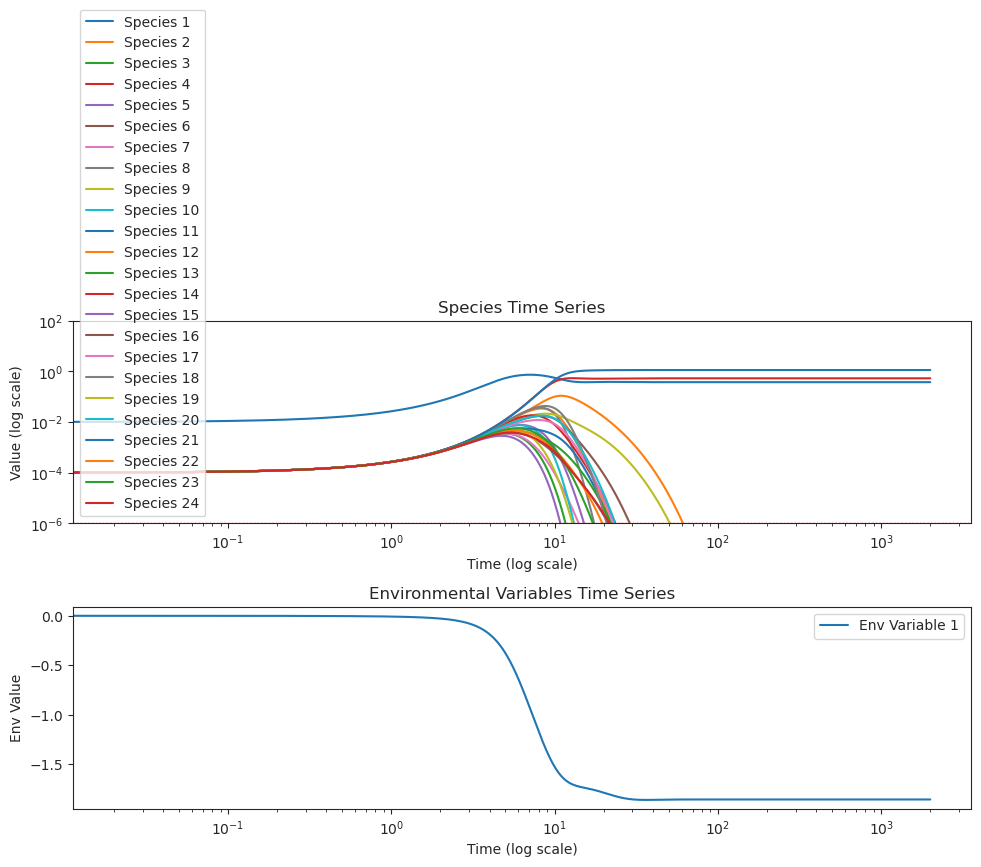

{'species': array([ 3.76115210e-01, -4.65685600e-34,  8.40847758e-28,  5.33979968e-01,
        2.41237501e-35,  9.18198803e-26,  2.27842722e-36,  6.59266932e-34,
       -6.93765989e-20,  9.51766129e-31, -3.85084564e-31, -1.26785225e-18,
        2.66021345e-29,  3.37776198e-30, -1.56282716e-23,  4.27444868e-28,
       -9.13673282e-31,  2.80342459e-33, -4.24917541e-34, -1.03109496e-30,
        1.13465740e+00, -7.70349310e-32, -1.05422779e-35,  3.17377959e-27,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([-1.85670502])}
2.0447525771134902 -1.8567050168586832


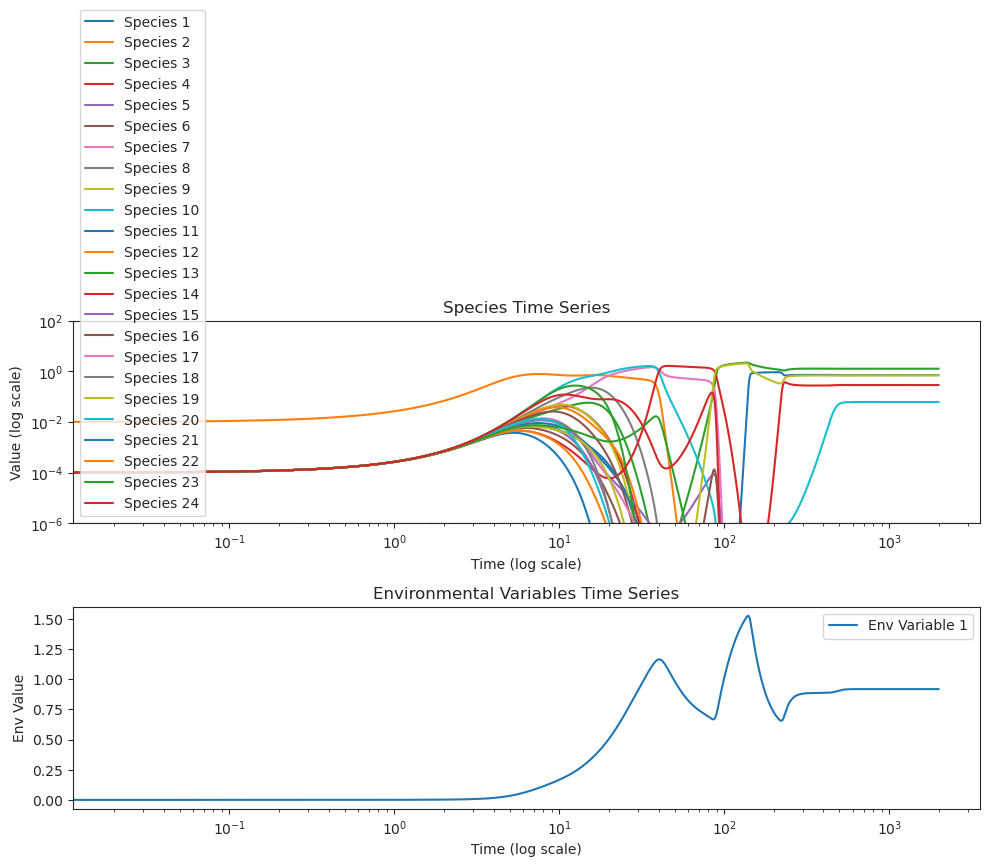

{'species': array([-2.86664219e-031, -3.13008864e-028,  1.28228083e+000,
       -6.50102191e-080, -2.39327093e-062, -7.91657830e-102,
        9.28116991e-072, -1.86183106e-100,  1.58152965e-077,
        6.18628731e-002,  7.14226085e-001,  4.14379951e-087,
       -3.34036715e-091,  2.90055242e-001, -2.71459763e-032,
       -6.60917975e-072,  4.33033974e-032,  1.15021682e-030,
        6.96319010e-001,  2.60310501e-091, -1.40104108e-099,
       -5.76579394e-074,  4.30716376e-057, -4.15784153e-058,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': arr

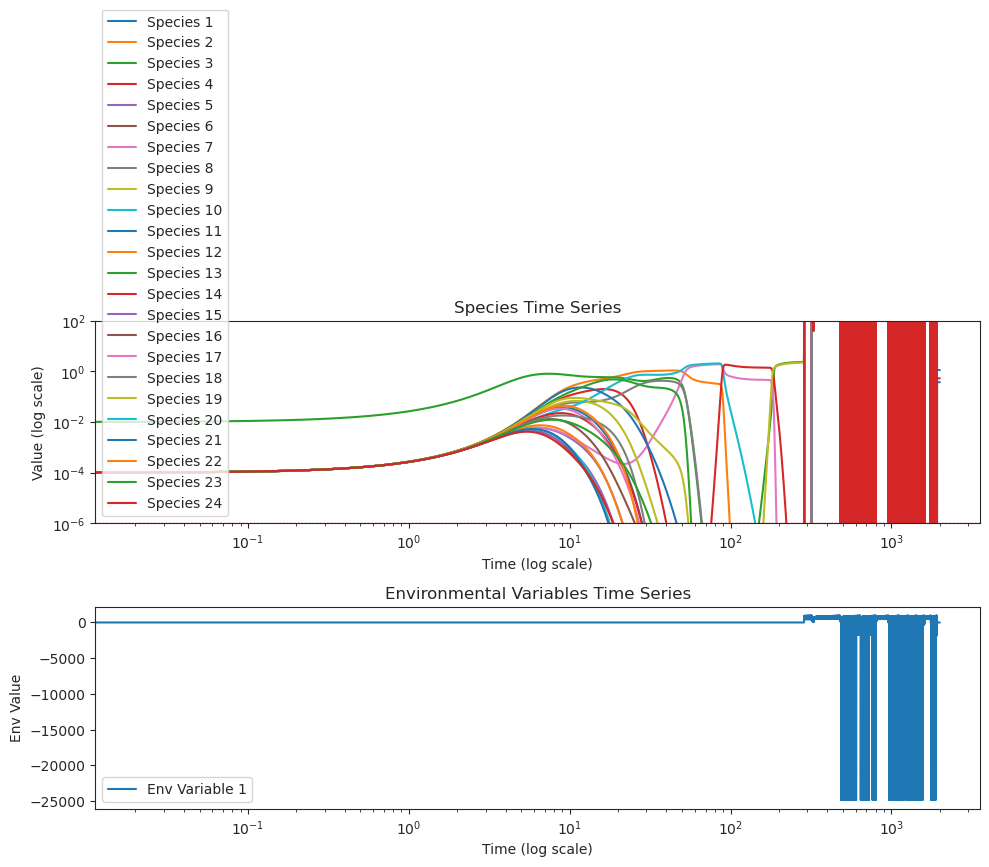

{'species': array([ 3.76115210e-01, -4.65685600e-34,  8.40847758e-28,  5.33979968e-01,
        2.41237501e-35,  9.18198803e-26,  2.27842722e-36,  6.59266932e-34,
       -6.93765989e-20,  9.51766129e-31, -3.85084564e-31, -1.26785225e-18,
        2.66021345e-29,  3.37776198e-30, -1.56282716e-23,  4.27444868e-28,
       -9.13673282e-31,  2.80342459e-33, -4.24917541e-34, -1.03109496e-30,
        1.13465740e+00, -7.70349310e-32, -1.05422779e-35,  3.17377959e-27,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([-1.85670502])}
2.0447525771134902 -1.8567050168586832


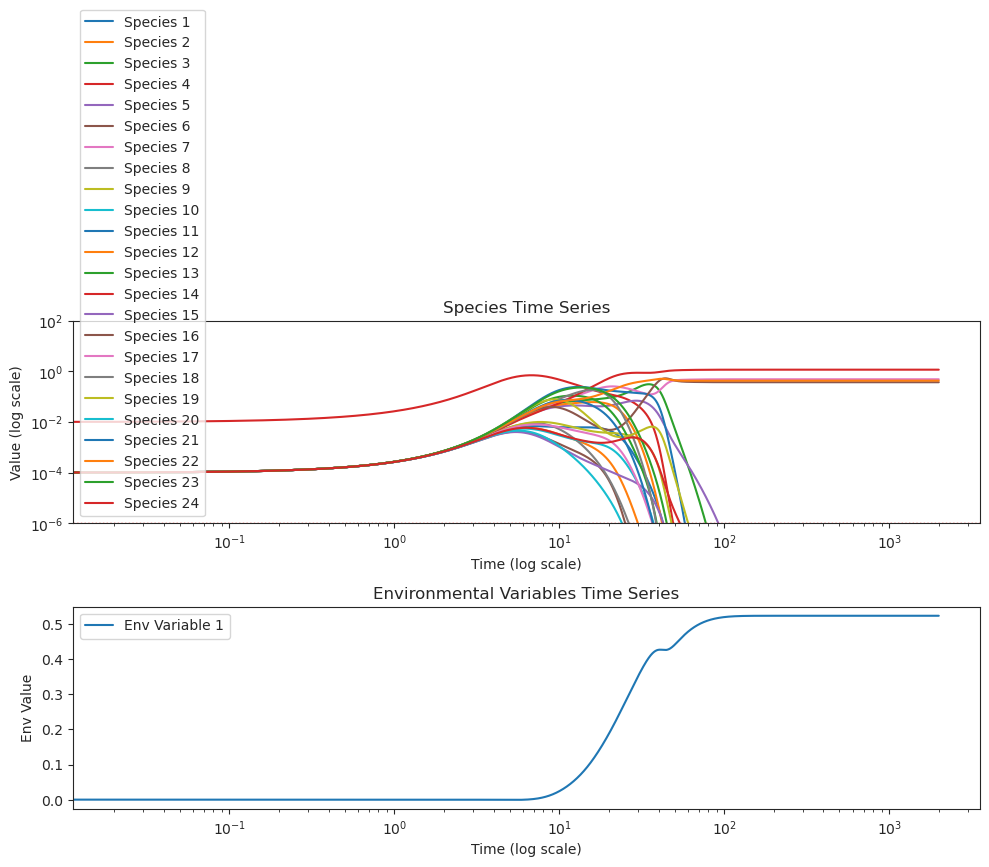

{'species': array([-4.65872208e-38,  1.37368701e-32,  1.02129757e-21, -9.35473817e-36,
        3.22396951e-17, -1.99901763e-21,  4.89950064e-01,  3.02208455e-33,
        3.45907902e-29, -4.13696257e-40, -8.24031721e-34, -1.62448547e-37,
       -3.78472238e-26,  1.17206970e+00, -1.92167005e-31,  3.73960317e-01,
       -6.16523658e-39, -2.20542224e-24,  5.59954187e-26,  2.29087931e-32,
        2.24089288e-38,  4.31801830e-01, -5.96146386e-37, -8.10783558e-23,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([0.52372036])}
2.4677819140731683 0.5237203551267617


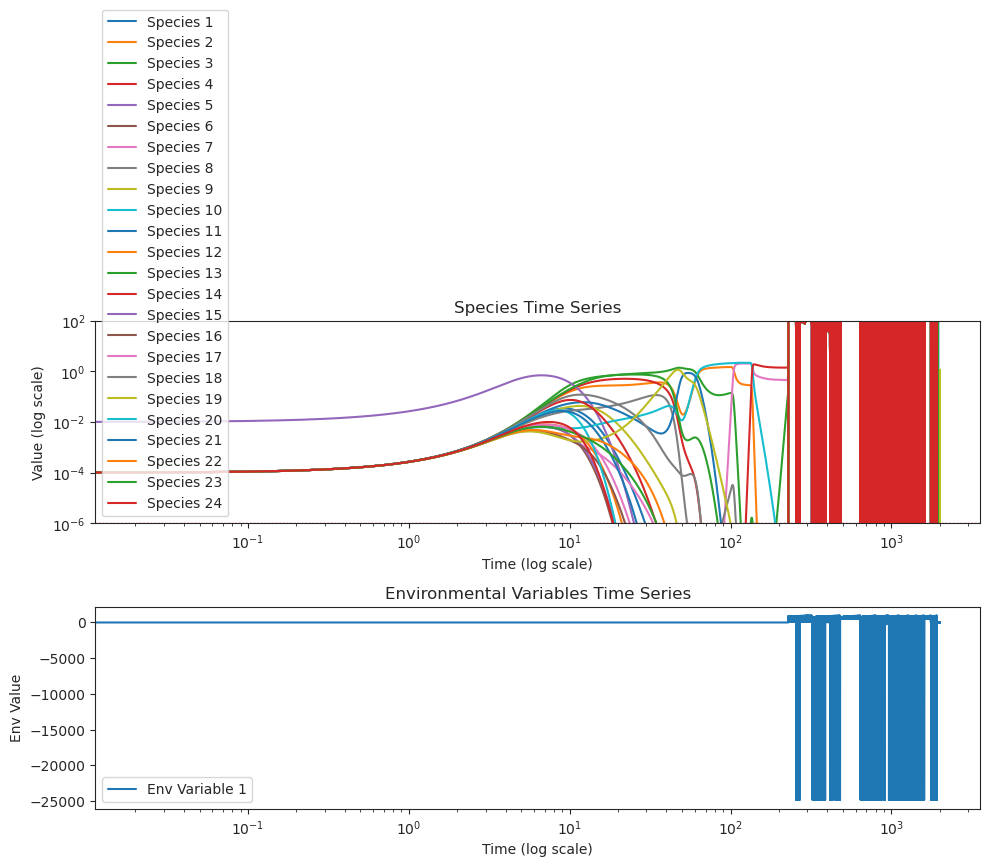

{'species': array([6.51877107e-310, 1.02280197e-311, 6.51877107e-310, 1.02492397e-311,
       6.51877107e-310, 1.02704596e-311, 6.51877107e-310, 1.02916796e-311,
       6.51877107e-310, 1.03128995e-311, 6.51877107e-310, 1.03341195e-311,
       6.51877107e-310, 1.03553395e-311, 6.51877107e-310, 1.03765594e-311,
       6.51877107e-310, 1.03977794e-311, 6.51877107e-310, 1.04189993e-311,
       6.51877107e-310, 1.04402193e-311, 6.51877107e-310, 1.04614393e-311,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]), 'env': array([6.51877107e-310])}
7.946662037652606e-309 6.51877106985796e-310


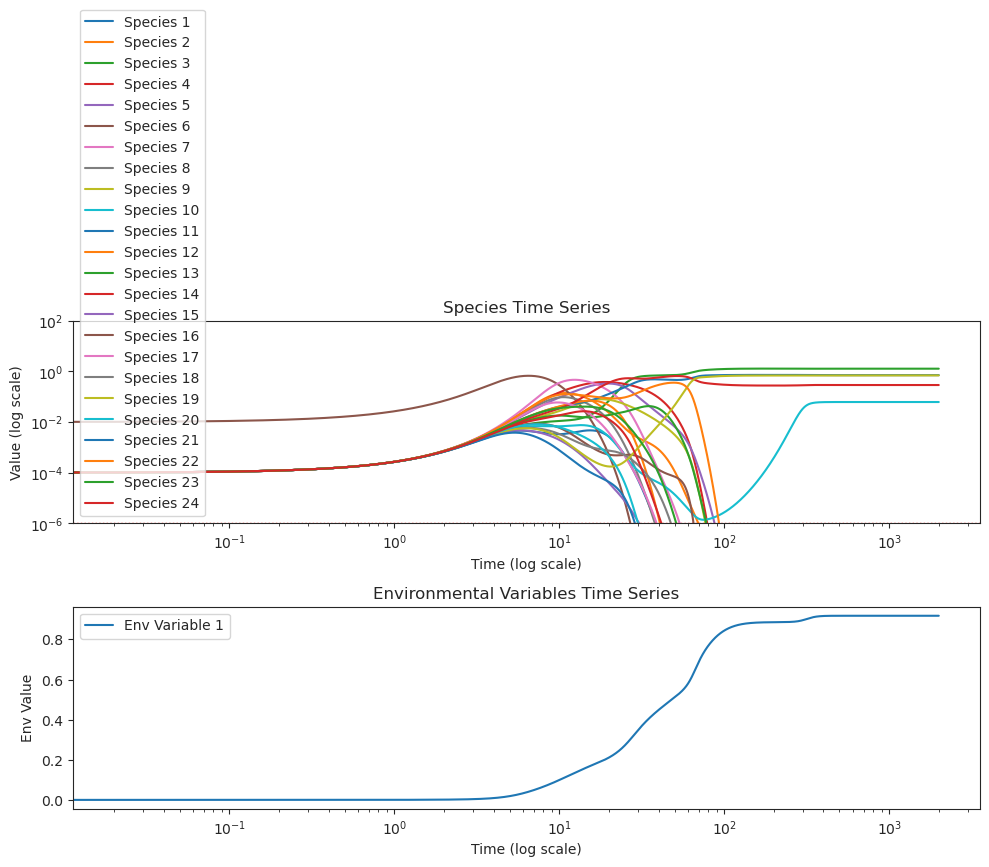

{'species': array([-1.02860152e-35, -3.87533438e-32,  1.28228083e+00,  8.26477184e-48,
        9.19847214e-41, -1.43087651e-47, -7.05049672e-49,  1.87434106e-49,
       -1.82078853e-48,  6.18628731e-02,  7.14226085e-01,  2.51894278e-35,
       -1.52020618e-43,  2.90055242e-01, -1.78165280e-48,  7.54873788e-44,
       -2.85273901e-36,  5.82215362e-35,  6.96319010e-01,  4.29609202e-32,
       -4.68710137e-31,  2.10141956e-45, -4.67180211e-45, -5.97149724e-38,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([0.9181231])}
3.0447440413267337 0.9181231046884089


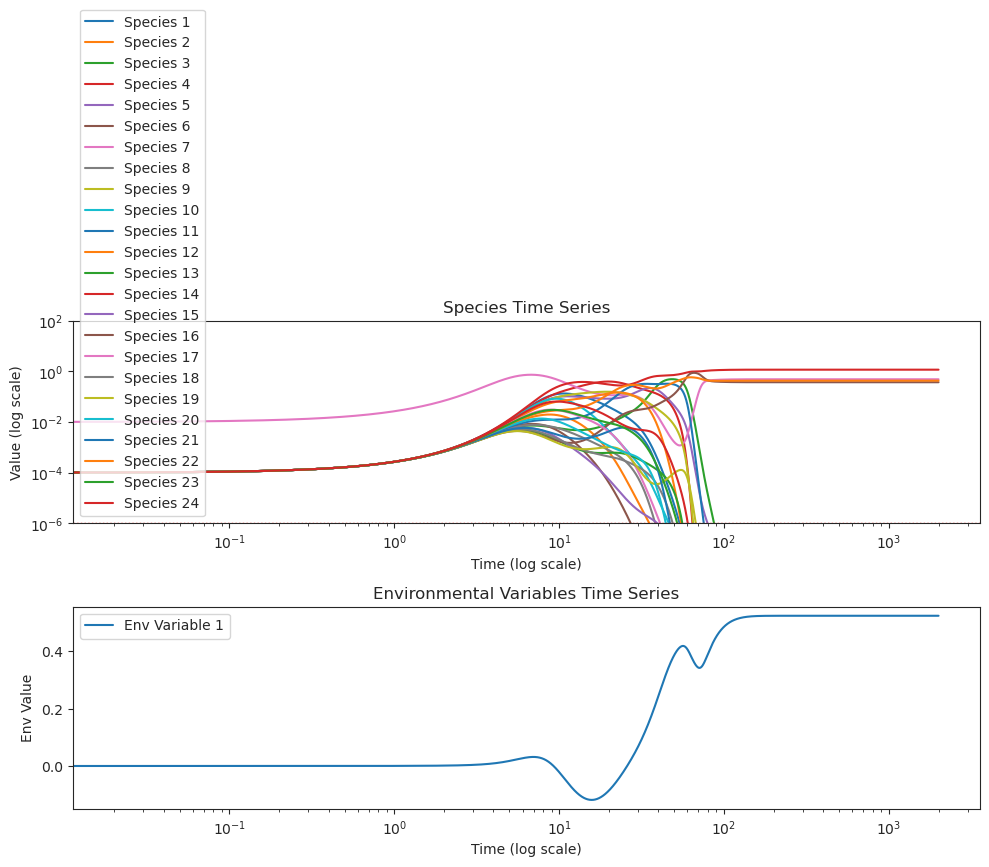

{'species': array([-1.60554514e-49, -3.53899370e-30,  2.20531714e-30, -1.19818352e-48,
        1.51517077e-23, -4.03283865e-22,  4.89950064e-01,  1.08371030e-29,
        1.56258091e-48,  5.88686409e-47,  3.17812733e-44, -1.08937692e-49,
       -2.59806024e-20,  1.17206970e+00,  5.32726167e-46,  3.73960317e-01,
       -2.39440386e-51, -1.93341468e-20, -7.26784973e-32,  1.02667072e-27,
       -2.53052387e-45,  4.31801830e-01, -6.76793379e-50,  2.19749201e-33,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([0.52372036])}
2.4677819142567134 0.5237203553537213


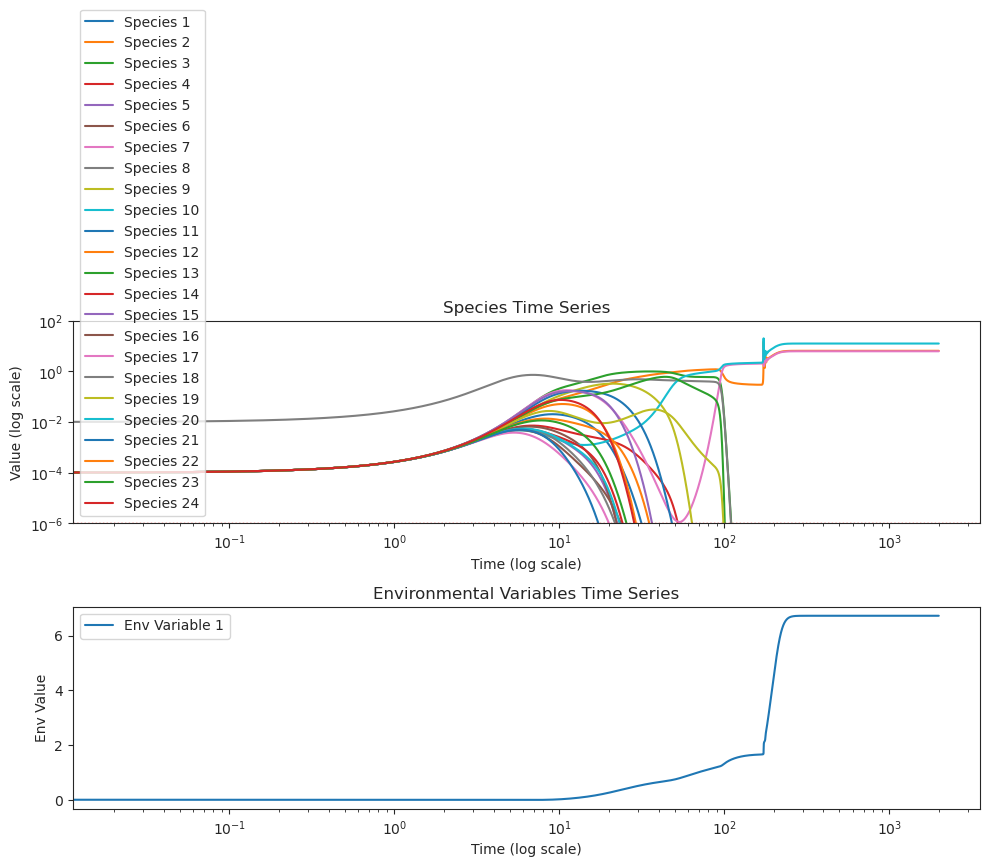

{'species': array([-2.18170906e-040,  6.51837376e+000,  3.36799936e-076,
        5.00112251e-050,  9.60445883e-069, -2.14607772e-075,
        6.24980301e+000,  7.59332354e-040,  1.72665518e-063,
        1.26254973e+001, -8.11298634e-207,  7.98017028e-066,
        1.89854866e-191, -5.91903479e+000,  7.63682769e-170,
        2.11185219e-225, -1.23323407e-218,  1.15074348e-189,
        2.39429826e-179,  1.21653269e-197,  8.35842005e-085,
        2.40540901e-190, -2.26230968e-032,  6.12529058e-200,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': arr

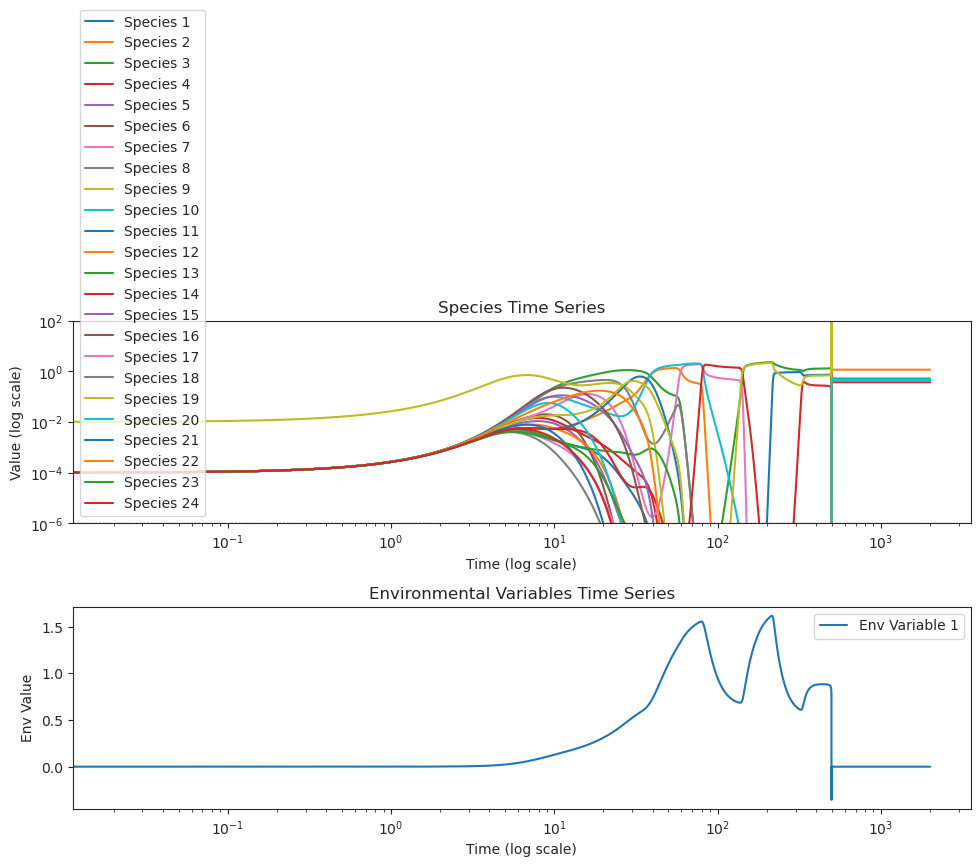

{'species': array([-2.83484619e-20,  1.17206970e+00,  5.81179602e-46,  3.73960317e-01,
       -2.61244364e-51, -2.10962629e-20, -7.92861945e-32,  1.12023467e-27,
       -2.76106597e-45,  4.31801830e-01, -7.38423421e-50,  2.39701996e-33,
        5.23720355e-01, -1.75167382e-49, -3.86141567e-30,  2.40562858e-30,
       -1.30726540e-48,  1.65235631e-23, -4.40031789e-22,  4.89950064e-01,
        1.18244699e-29,  1.70476627e-48,  6.42294708e-47,  3.46742382e-44,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([-1.18856458e-49])}
2.9915022696104208 -1.1885645820592133e-49


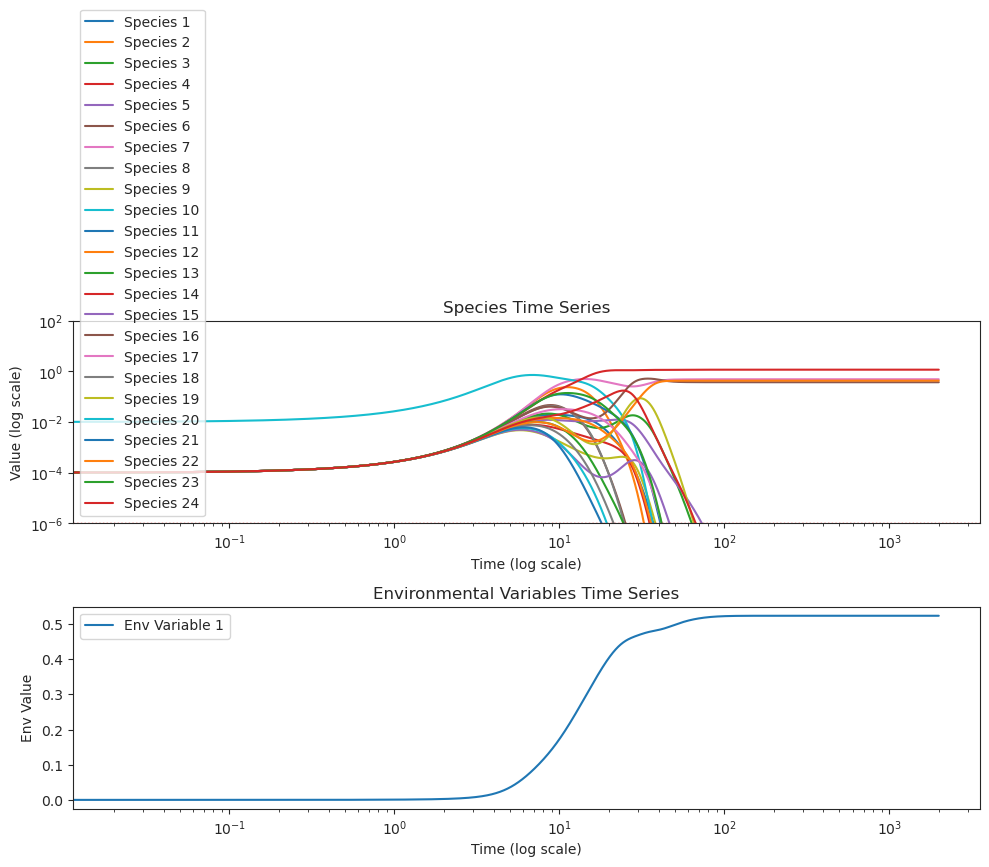

{'species': array([-2.39949128e-35, -1.89419063e-33, -4.01270658e-30, -5.50583423e-37,
       -2.48126843e-25, -1.13014872e-27,  4.89950064e-01,  3.53090561e-31,
       -6.62463131e-35,  9.63378126e-37, -8.15509737e-35, -1.44814806e-36,
        2.49447429e-30,  1.17206970e+00, -1.15373040e-31,  3.73960317e-01,
       -1.24598753e-34, -3.48201145e-30, -7.50537637e-28,  5.65621991e-33,
       -9.24347469e-41,  4.31801830e-01, -1.01307621e-34, -3.59491155e-27,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), 'env': array([0.52372036])}
2.467781914256782 0.5237203553538076


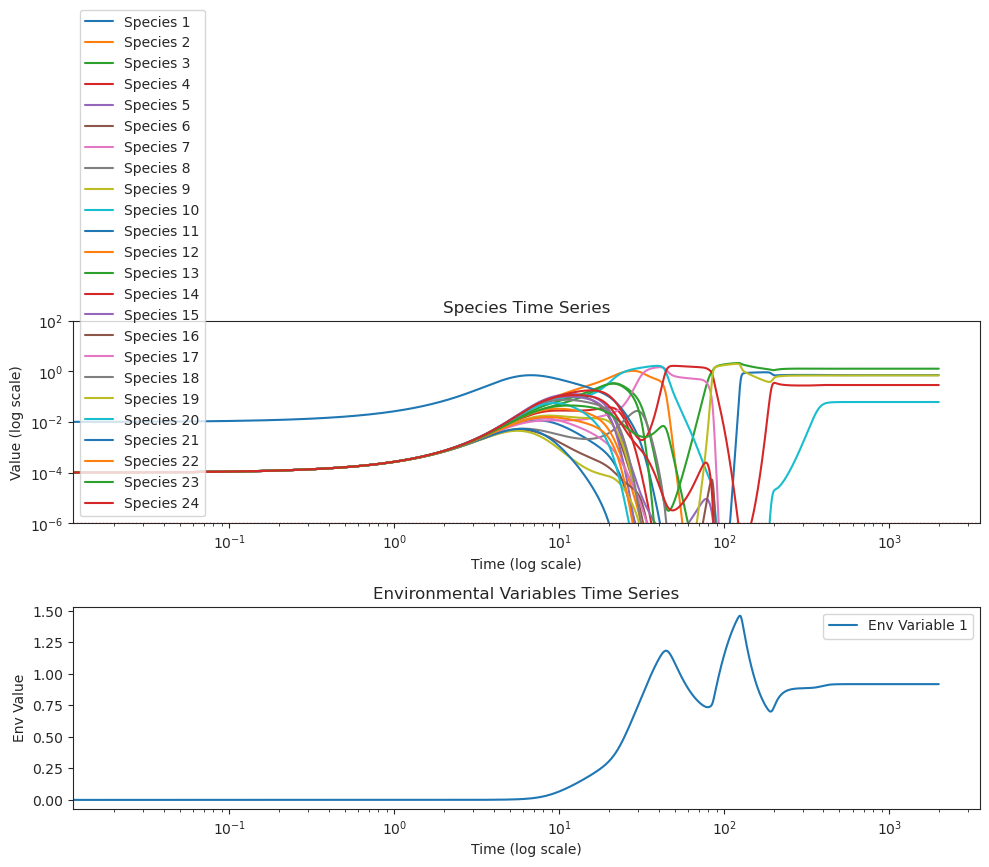

{'species': array([-1.38855971e-033,  1.59144918e-033,  1.28228083e+000,
       -2.91410871e-091,  1.45829896e-034, -1.30223387e-099,
        8.10502701e-083,  2.34715975e-103,  2.64201573e-085,
        6.18628731e-002,  7.14226085e-001,  5.75707114e-069,
       -2.17761524e-088,  2.90055242e-001,  2.48115964e-080,
        7.17235766e-073, -1.63176818e-034,  1.47982448e-067,
        6.96319010e-001,  4.24278192e-057, -2.56634291e-065,
        2.30318263e-082,  4.42950249e-056,  2.62328313e-040,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), 'env': arr

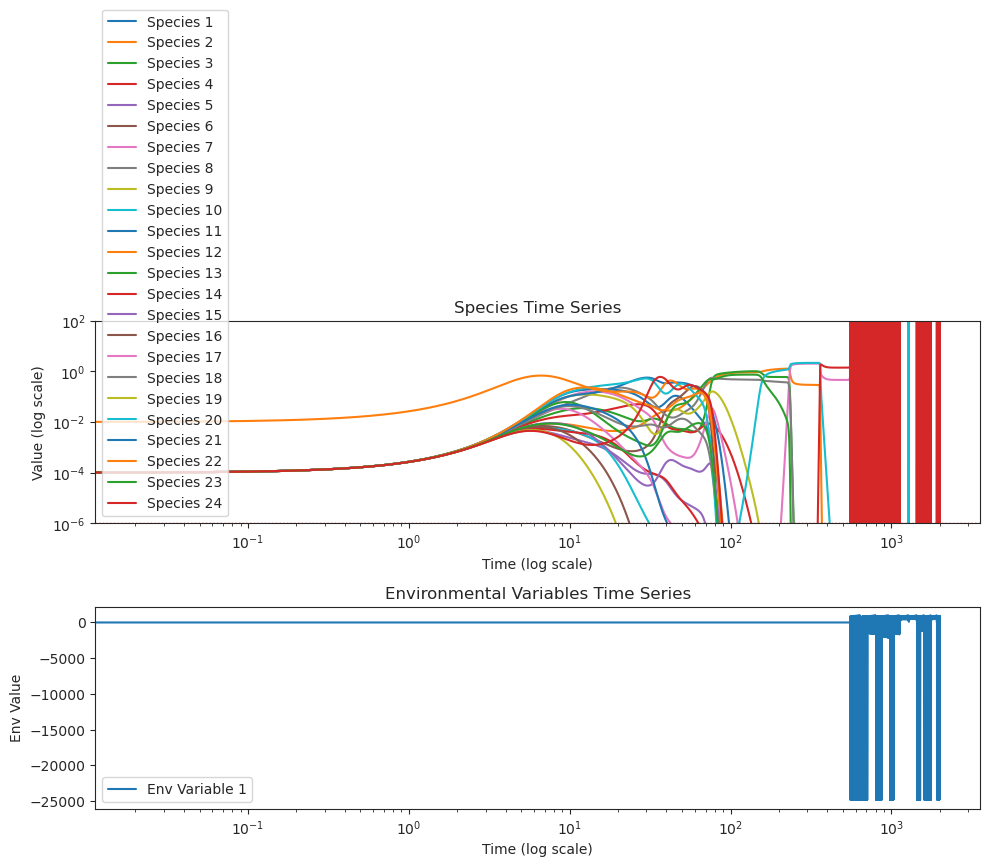

{'species': array([-1385.95084121,   889.07629607, -1385.96258098,   889.07772944,
       -1385.9743333 ,   889.07916279, -1385.98609819,   889.0805961 ,
       -1385.99787569,   889.08202939, -1386.00966581,   889.08346265,
       -1386.02146858,   889.08489588, -1386.03328404,   889.08632909,
       -1386.0451122 ,   889.08776226, -1386.0569531 ,   889.0891954 ,
       -1386.06880677,   889.09062852, -1386.08067322,   889.09206161,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ]), 'env': array([-1386.0925525])}
-5963.177543891807 -1386.092552496631


In [12]:
system_config['beta'] = np.array([0.5])*delta

species_index=np.arange(0,24)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(24,i)
    y0_env=[0]
    t=np.linspace(0, 2000, 100000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)
    print(np.sum(y_out['species']), np.sum(y_out['env']) )

In [ ]:
y_out

In [ ]:
np.linspace(0, 1000, 5000)

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([0.002])

for i in range(20):
    species_index=np.random.choice(48, size=12, replace=False)
    env_index=np.array([0])
    y0_species=np.random.rand(12)*0.01
    y0_env=[0]
    t=np.linspace(0, 5000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([0.2])

for i in range(12):
    species_index=np.random.choice(48, size=12, replace=False)
    env_index=np.array([0])
    y0_species=np.random.rand(12)*0.01
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)

In [ ]:
system_config

In [ ]:
system_config

In [ ]:
np.random.seed(42)
system_config['beta'] = np.array([40])

species_index=np.arange(0,12)
env_index=np.array([0])

for i in range(12):
    y0_species=one_hot_vector(12,i)
    y0_env=[0]
    t=np.linspace(0, 1000, 5000)

    y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)